In [142]:
# modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import regularizers, backend
from keras.datasets import fashion_mnist
# Importing core neural networks layers 
from keras.layers import Dense, Dropout, Activation, Flatten, UpSampling2D, BatchNormalization, Lambda
# Importing CNN layers
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Input, Embedding, LSTM, ELU
# Importing the sequential model in Keras
# Used as a linear stack of nn layers
from keras.models import Sequential, Model
# Tools for data transformation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.sequence import pad_sequences
from string import printable
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# 3 Text Classification
While images contain local spatial correlations and structure, many other datasets contain temporal correlations. Examples include time series and discrete se- quences such as text. In this problem, we will tackle the task of text classifica- tion in the context of cybersecurity.<br/>
&nbsp;&nbsp;<b>Background.</b> When malware infects a host computer, it often needs to reach out to an outside server for further instructions or to download additional payloads. This outside server is called a Command-and-Control server (C2). The malware needs to send a specific communication to the C2 server, thus the C2 server needs to have a registered IP address or associated web domain so that it can be reached. Therefore, being able to identify web domains that are likely related to malware C2 can be a valuable cyber defense.<br/>
&nbsp;&nbsp;<b>Dataset.</b> Fortunately, security researchers have already identified and logged a large number of malicious URLs. Additionally, we can catalog common ”be- nign” URLs just from typical web behavior (these would include things like facebook.com and amazon.com). Hence, we have a labeled dataset for text classification which can be downloaded here:
<br/>• https://s3.amazonaws.com/anly-590/url-classification/benign-urls.txt
<br/>• https://s3.amazonaws.com/anly-590/url-classification/malicious-urls.txt
## 3.1 RNN
Build and train a Recurrent Neural Network to solve this text classification task. You can use any type of RNN you wish (SimpleRNN, GRU, LSTM).
## 3.2 CNN
Build and train a 1D CNN for this text classification task. You might gain some insight and inspiration from these text classification approaches:
<br/>• http://www.aclweb.org/anthology/D14-1181 
<br/>• https://arxiv.org/abs/1702.08568
## 3.3
Be sure to directly compare your two methods with an ROC curve or similar validation method. Don’t forget to create a train-test split.

In [144]:
# 3.1 RNN

# Load data-sets
def read_file( file_name ):
    with open( file_name ) as file:
        lines = file.readlines()
    return [ line.rstrip("\n\t") for line in lines[ 0: ] ]

mal_urls = read_file( 'malicious-urls.txt' )
ben_urls = read_file( 'benign-urls.txt' )

In [145]:
# Data preparation
df = pd.DataFrame({'urls':mal_urls+ben_urls, 'label':np.concatenate( [ np.ones(len(ben_urls)), np.zeros(len(mal_urls)) ])})
url_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.urls]
x_train, x_test, y_train, y_test = train_test_split(pad_sequences(url_tokens, maxlen=75), np.array(df.label), test_size=0.25, random_state=33)

In [146]:
# Build a model
rnn_model = Sequential()
rnn_model.add(Embedding(100, 32))
rnn_model.add(LSTM(32))
rnn_model.add(Dense(1, activation ='sigmoid'))
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 32)          3200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 33        
Total params: 11,553
Trainable params: 11,553
Non-trainable params: 0
_________________________________________________________________


In [147]:
# Compile model
rnn_model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
# Train model
history = rnn_model.fit(x_train, y_train, 
                    epochs = 100, batch_size = 64, 
                    validation_split = 0.2, verbose=1, 
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')])

Train on 40411 samples, validate on 10103 samples
Epoch 1/100
40411/40411 [==============================] - 57s 1ms/step - loss: 0.0726 - acc: 0.9827 - val_loss: 0.0350 - val_acc: 0.9909
Epoch 2/100
40411/40411 [==============================] - 56s 1ms/step - loss: 0.0297 - acc: 0.9932 - val_loss: 0.0247 - val_acc: 0.9939
Epoch 3/100
40411/40411 [==============================] - 53s 1ms/step - loss: 0.0253 - acc: 0.9942 - val_loss: 0.0225 - val_acc: 0.9940
Epoch 4/100
40411/40411 [==============================] - 52s 1ms/step - loss: 0.0234 - acc: 0.9944 - val_loss: 0.0228 - val_acc: 0.9940
Epoch 5/100
40411/40411 [==============================] - 53s 1ms/step - loss: 0.0225 - acc: 0.9944 - val_loss: 0.0211 - val_acc: 0.9940
Epoch 6/100
40411/40411 [==============================] - 55s 1ms/step - loss: 0.0212 - acc: 0.9946 - val_loss: 0.0211 - val_acc: 0.9940
Epoch 7/100
40411/40411 [==============================] - 57s 1ms/step - loss: 0.0208 - acc: 0.9944 - val_loss: 0.0194 - 

In [148]:
#  Evaluating the model
rnn_score = rnn_model.evaluate(x_test, y_test, verbose=1)
print(score)

16839/16839 [==============================] - 5s 289us/step
[0.028990465670625593, 0.9941207910208445]


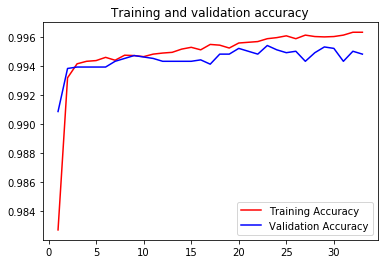

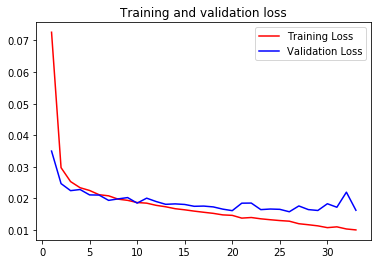

In [149]:
# Plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'r', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Training + Validation Loss
epochs = range(1,len(loss) + 1)
plt.plot( epochs, loss, 'r', label = 'Training Loss')
plt.plot( epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [125]:
# 3.2 CNN

# Load data-sets
def read_file( file_name ):
    with open( file_name ) as file:
        lines = file.readlines()
    return [ line.rstrip("\n\t") for line in lines[ 0: ] ]

mal_urls = read_file( 'malicious-urls.txt' )
ben_urls = read_file( 'benign-urls.txt' )

In [126]:
# Data preparation
df = pd.DataFrame({'urls':mal_urls+ben_urls, 'label':np.concatenate( [ np.ones(len(ben_urls)), np.zeros(len(mal_urls)) ])})
url_tokens = [[printable.index(x) + 1 for x in url if x in printable] for url in df.urls]
x_train, x_test, y_train, y_test = train_test_split(pad_sequences(url_tokens, maxlen=75), np.array(df.label), test_size=0.25, random_state=33)

In [137]:
def sum_1d(X):
    return backend.sum(X, axis=1)

# Build a model
model = Sequential()
model.add(Embedding(input_dim=100, output_dim=32, 
                    input_length=75))
model.add(Dropout(0.25))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', border_mode='same'))
model.add(ELU())
model.add(Lambda(sum_1d, output_shape=(256,)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(ELU())
model.add(BatchNormalization(mode=0))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", activation="relu", kernel_size=2, filters=256)`
  if __name__ == '__main__':
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization()`
  from ipykernel import kernelapp as app


In [138]:
# Compile model
model.compile(optimizer = 'rmsprop',
             loss = 'binary_crossentropy',
             metrics=['acc'])
# Train model
history = model.fit(x_train, y_train, 
                    epochs = 100, batch_size = 64, 
                    validation_split = 0.2, verbose=1, 
                    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='auto')])

Train on 40411 samples, validate on 10103 samples
Epoch 1/100
40411/40411 [==============================] - 21s 524us/step - loss: 0.1118 - acc: 0.9635 - val_loss: 0.0765 - val_acc: 0.9876
Epoch 2/100
40411/40411 [==============================] - 21s 520us/step - loss: 0.0463 - acc: 0.9897 - val_loss: 0.0318 - val_acc: 0.9935
Epoch 3/100
40411/40411 [==============================] - 18s 453us/step - loss: 0.0406 - acc: 0.9909 - val_loss: 0.0371 - val_acc: 0.9915
Epoch 4/100
40411/40411 [==============================] - 20s 485us/step - loss: 0.0386 - acc: 0.9912 - val_loss: 0.0444 - val_acc: 0.9899
Epoch 5/100
40411/40411 [==============================] - 20s 486us/step - loss: 0.0386 - acc: 0.9912 - val_loss: 0.0339 - val_acc: 0.9933
Epoch 6/100
40411/40411 [==============================] - 19s 481us/step - loss: 0.0373 - acc: 0.9916 - val_loss: 0.0300 - val_acc: 0.9934
Epoch 7/100
40411/40411 [==============================] - 22s 545us/step - loss: 0.0369 - acc: 0.9921 - val_l

In [139]:
#  Evaluating the model
cnn_score = model.evaluate(x_test, y_test, verbose=1)
print(score)

16839/16839 [==============================] - 3s 188us/step
[0.028990465670625593, 0.9941207910208445]


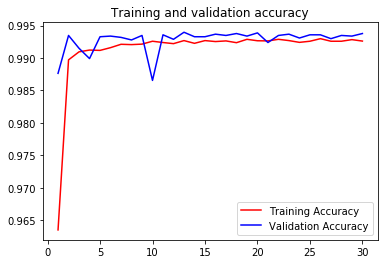

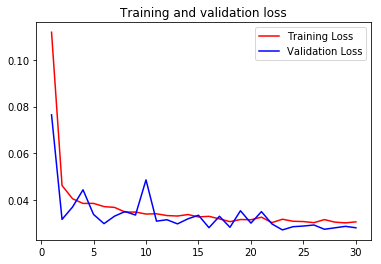

In [140]:
# Plot
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Training + Valdiation Accuracy
epochs = range(1,len(acc) + 1)
plt.plot( epochs, acc, 'r', label = 'Training Accuracy')
plt.plot( epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# Training + Validation Loss
epochs = range(1,len(loss) + 1)
plt.plot( epochs, loss, 'r', label = 'Training Loss')
plt.plot( epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [150]:
# 3.2

# RNN
rnn_pred = rnn_model.predict(x_test).ravel()
rnn_fpr, rnn_tpr, rnn_thresholds = roc_curve(y_test, rnn_pred)
rnn_auc = auc(rnn_fpr, rnn_tpr)

# CNN
cnn_pred = model.predict(x_test).ravel()
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(y_test, cnn_pred)
cnn_auc = auc(cnn_fpr, cnn_tpr)

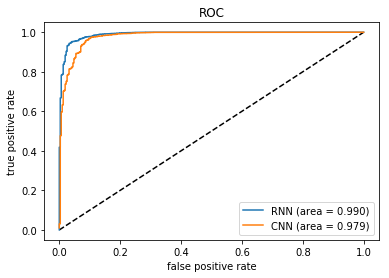

In [151]:
# Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rnn_fpr, rnn_tpr, label='RNN (area = {:.3f})'.format(rnn_auc))
plt.plot(cnn_fpr, cnn_tpr, label='CNN (area = {:.3f})'.format(cnn_auc))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC')
plt.legend(loc='best')
plt.show()